In [ ]:
#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@File    :   data_prepare_3d.py
@Time    :   2021/06/24 17:19:48
@Author  :   Dio Chen
@Version :   1.0.0
@Contact :   zhuo.chen@wuerzburg-dynamics.com
@License :   None
@Desc    :   None
'''

# here put the import lib
import os
import math
import json

import torch
import numpy as np
import SimpleITK as sitk
from utils.config import Config

from utils.data_utils import z_resample, data_windowing, data_crop, get_area
from utils.data_utils import load_nii, save_to_nii, crop_area
from utils.data_utils import get_trans_compose, change_label
import pandas as pd
from PIL import Image
from utils.visualization import show_views


class DataPrepare3D:
    def __init__(self, config: Config):

        self.root_path = config.root_path
        self.layer_thick = config.layer_thick

        self.thickness = config.thickness
        self.ct_stage = config.ct_stage  # normal, enh_a, enh_d

        self.area_size = config.area_size
        self.resize_xy = config.resize_xy

        self.case_imgs_name = config.case_imgs_name
        self.case_mask_name = config.case_mask_name
        self.windowing = config.windowing
        self.stride = config.stride
        self.trans_types = config.trans_types
        self.change_label = config.change_label

        self.crop_dataset_path = config.crop_dataset_path
        self.origin_image = config.image_3d_path
        self.origin_mask = config.mask_3d_path

        self.crop_xy = config.crop_xy

    @staticmethod
    def load_data(img_path, mask_path):
        """load image, mask and ct infomation

        Args:
            img_path (str): path of image
            mask_path (str): path of mask

        Returns:
            [type]: img_arr, mask_arr, case_id, ct_info
        """
        case_name = img_path.split('/')[-2]
        img_info = load_nii(img_path, channels_last=False)
        mask_info = load_nii(mask_path, channels_last=False)

        img_arr = img_info['img_arr']
        mask_arr = mask_info['img_arr']
        print(img_path, '-----------------------------------------')
        return img_arr, mask_arr, case_name, img_info, mask_info

    def save_data(self, img, mask, save_name, ct_info):
        """save image, mask

        Args:
            img_path (str): path of image
            mask_path (str): path of mask
            save_name (str): output name
        """
        save_to_nii(self.origin_image, save_name, img, ct_info, suffix=self.case_imgs_name)
        save_to_nii(self.origin_mask, save_name, mask, ct_info, suffix=self.case_mask_name)

    def preprocess(self, img_arr, mask_arr, ct_info):
        """ data preprocess

        Args:
            img_arr (np): image array
            mask_arr (np): mask array
            ct_info (dict): ct infomation

        Returns:
            [type]: processed image, processed mask, new ct information, old_spacing
        """
        # change label
        # print('unique', np.unique(mask_arr))
        # mask_arr = change_label(mask_arr, self.change_lable)
        # print('change unique', np.unique(mask_arr))

        # resample
        old_spacing = ct_info['space']
        img_arr, new_spacing = z_resample(img_arr, old_spacing, re_thickness=self.thickness, re_xy=self.resize_xy)
        mask_arr, _ = z_resample(mask_arr, old_spacing, re_thickness=self.thickness, re_xy=self.resize_xy)

        # Windowing
        img_arr = data_windowing(img_arr, self.windowing)
        mask_arr = data_windowing(mask_arr, self.windowing)

        # z pading
        if img_arr.shape[0] < self.layer_thick:
            p = self.layer_thick - img_arr.shape[0]
            img_arr = np.pad(img_arr, ((0, p), (0, 0), (0, 0)), 'minimum')
            mask_arr = np.pad(mask_arr, ((0, p), (0, 0), (0, 0)), 'minimum')
        print('pading shape', img_arr.shape, mask_arr.shape, self.layer_thick)
        assert img_arr.shape[0] >= self.layer_thick and mask_arr.shape[0] >= self.layer_thick

        # change spacing
        ct_info['space'] = tuple(new_spacing)

        return img_arr, mask_arr, ct_info, old_spacing

    def get_valid_thickness(self, img_arr, mask_arr):
        """get valid thickness in data array

        Args:
            img_arr (np): image array
            mask_arr (np): mask array

        Returns:
            [type]: valid image, valid mask array
        """
        loc = np.where(mask_arr > 0)

        z_loc = loc[0]
        z_max = z_loc.max()
        z_min = z_loc.min()

        thickness = img_arr.shape[0]
        min_thickness = self.thickness

        z_min = z_min - 5 if z_min - 5 >= 0 else 0
        z_max = z_max + 5 if z_max + 5 <= thickness else thickness

        print(z_min, z_max)
        if z_max - z_min < min_thickness:
            if z_min == 0:
                z_max = min_thickness
            elif z_max == thickness:
                z_min = thickness - min_thickness
            elif z_min != 0 and z_max != thickness:
                print('z_min != 0 and z_max != thickness', z_min, z_max)
                value = min_thickness - (z_max - z_min)
                if z_max + value <= thickness:
                    z_max = z_max + value
                else:
                    z_max = thickness
                    z_min = thickness - min_thickness

        else:
            z_max = z_max
            z_min = z_min

        mask_valid = mask_arr[z_min:z_max, :, :]
        img_valid = img_arr[z_min:z_max, :, :]

        return img_valid, mask_valid, z_max, z_min

    @staticmethod
    def change_label(label, trans_dict):
        """change label value by train_dict, will copy the arr first

        :param label：
        :param trans_dict: (dict): {'1':0, '2':1} value 1 to 0, value 2 to 1
        Returns:
            label_cp: new label
        """

        label_cp = label.copy()
        label_cp = change_label(label_cp, trans_dict)
        return label_cp

    def xy_crop(self, arr):
        """crop data from x,y axis

        Args:
            arr ([type]): crop_arr
        """
        arr = np.expand_dims(arr, 0)
        arr = data_crop(arr, self.crop_xy)
        arr = np.squeeze(arr, 0)
        return arr

    @staticmethod
    def get_kidney_area(mask):
        """get each kidney area, will copy the arry first

        Args:
            mask (np): mask array

        Returns:
            kidney_area: each kidney area infomation
        """
        mask_cp = mask.copy()
        mask_cp[mask_cp > 0] = 1
        kidney_area = get_area(mask_cp)

        if len(kidney_area) >= 2:
            kidney_num = 2
        else:
            kidney_num = len(kidney_area)
        kidney_area = kidney_area[:kidney_num]
        return kidney_area

    def crop_area(self, image, mask, area_info):
        """crop each kidney area

        Args:
            image (np): image array
            mask (np): mask array
            area_info (dict): area infomation dict
        Returns:
            mask_crop, img_crop, is_normal, crop_edge
        """

        mask_crop, img_crop, is_normal, crop_edge = crop_area(mask.copy(), image, area_info, self.area_size)
        return mask_crop, img_crop, is_normal, crop_edge

    @staticmethod
    def info_to_json(file_path, info):
        with open(file_path, 'w') as f:
            json.dump(info, f)

    def transform_to_3d(self, cases_name, img_output, mask_output, coarse=True):
        """transform image to 3D block

        Args:
            cases_name (dict ): cases_name {"cases_name":[case_00160,case_00100]}
            coarse: for coarse network to 3d
            img_output (str): output path of 3D block
            mask_output (str): output path of 3D block
        """

        if not os.path.exists(img_output):
            os.mkdir(img_output)

        if not os.path.exists(mask_output):
            os.mkdir(mask_output)
        for case_name in cases_name["cases_name"]:
            print(case_name)
            img_path = os.path.join(self.origin_image, case_name+".nii.gz")
            mask_path = os.path.join(self.origin_mask, case_name+".nii.gz")
            # read origin case data
            # 512
            img_nii = sitk.ReadImage(img_path)
            mask_nii = sitk.ReadImage(mask_path)
            img_arr = sitk.GetArrayFromImage(img_nii).astype(np.float32).transpose((2, 1, 0))
            mask_arr = sitk.GetArrayFromImage(mask_nii).astype(np.uint8).transpose((2, 1, 0))
            # remove the diff shape ,h and w
            if coarse:
                img_arr = self.xy_crop(img_arr)
                mask_arr = self.xy_crop(img_arr)
            if img_arr.shape[1] != self.area_size[1] or img_arr.shape[2] != self.area_size[
                    2] or img_arr.shape != mask_arr.shape:
                continue
            # print(img_arr.shape)
            # crop data block
            voxel_z = mask_arr.shape[0]
            target_gen_size = self.layer_thick
            range_val = int(math.ceil((voxel_z - target_gen_size) / self.stride) + 1)

            for i in range(range_val):
                fileid = case_name + "-" + '%03d' % i
                print(fileid)

                start_num = i * self.stride
                end_num = start_num + target_gen_size
                print('total:', voxel_z, 'start_end:', start_num, end_num)
                if end_num <= voxel_z:
                    # 数据块长度没有超出x轴的范围,正常取块
                    img = img_arr[start_num:end_num, :, :]
                    mask = mask_arr[start_num:end_num, :, :]
                else:
                    # 数据块长度超出x轴的范围, 从最后一层往前取一个 batch_gen_size 大小的块作为本次获取的数据块
                    img = img_arr[(voxel_z - target_gen_size):voxel_z, :, :]
                    mask = mask_arr[(voxel_z - target_gen_size):voxel_z, :, :]

                img = torch.from_numpy(img)
                mask = torch.from_numpy(mask.astype(np.uint8))

                img = torch.unsqueeze(img, dim=0)
                mask = torch.unsqueeze(mask, dim=0)

                torch.save(img, os.path.join(img_output, fileid + '.pth'))
                torch.save(mask, os.path.join(mask_output, fileid + '.pth'))
                # print(os.path.join(img_output, fileid + '.pth'))
                print(os.path.join(mask_output, fileid + '.pth'))

                assert img.shape[1] == self.layer_thick and mask.shape[1] == self.layer_thick
                # print(self.trans_types, np.unique(mask))
                if len(self.trans_types) > 0 and mask.any() > 0:
                    # augmentation
                    for j, trans in enumerate(self.trans_types):
                        seed = np.random.randint(2147483647)
                        img_aug, mask_aug = self.data_augmentation(img, mask, trans, seed)

                        assert torch.max(mask_aug) <= torch.max(
                            torch.unique(mask)) and torch.min(mask_aug) >= torch.min(torch.unique(mask))

                        # print(img_aug.shape, mask_aug.shape)
                        # xcd:bug???
                        assert img_aug.shape[1] == self.layer_thick and mask_aug.shape[1] == self.layer_thick, \
                            f"image:{img_aug.shape}, layer_thick_{self.layer_thick}"

                        aug_name = fileid + '-' + '%02d' % j + '.pth'
                        torch.save(img_aug, os.path.join(img_output, aug_name))
                        torch.save(mask_aug, os.path.join(mask_output, aug_name))
                        # print(os.path.join(img_output, aug_name))
                        # print(os.path.join(mask_output, aug_name))
            print('*' * 30)

    @staticmethod
    def data_augmentation(img, mask, trans_type, rand_seed):
        """data augmentation for img and mask

        Args:
            img : image [C, D1, D2, D3...]
            mask : mask [C,  D1, D2, D3...]
            trans_type (optional): type of data transforms.
            rand_seed (optional): random seed for transforms.

        Returns:
            image_aug, mask_aug
        """
        img_fill = img.min().item()
        # print(img.shape, img_fill)
        img_copy = img.clone().squeeze(dim=0)
        mask_copy = mask.clone().squeeze(dim=0)
        img_tran = get_trans_compose(trans_type, img_fill, 'image')
        mask_tran = get_trans_compose(trans_type, 0, 'mask')

        if rand_seed is not None:
            torch.manual_seed(rand_seed)  # apply this seed to img tranfsorms
        # print(img_tran(img_copy).shape)
        img_aug = img_tran(img_copy).unsqueeze(dim=0)
        # print(img_aug.shape)
        # print(img_aug.dtype)

        if rand_seed is not None:
            torch.manual_seed(rand_seed)  # apply this seed to img tranfsorms
        mask_aug = mask_tran(mask_copy).unsqueeze(dim=0)

        return img_aug, mask_aug

    @staticmethod
    def get_kidney_dict(case_name,
                        img_shape,
                        old_spacing,
                        new_spacing,
                        area_info=None,
                        is_normal=None,
                        crop_edge=None):
        """get kidney dict consist of kidney information

        Args:
            case_name (str): ct name
            img_shape (tuple): shape of image array
            old_spacing (tuple): spacing before resample
            new_spacing (tuple): spacing after resample
            area_info (dict, optional): area information. Defaults to None.
            is_normal (bool, optional): is a normal kidney. Defaults to None.
            crop_edge (list, optional): crop edge. Defaults to None.

        Returns:
            kidney_dict: kidney information dict
        """

        kidney_dict = {
            "case_name": case_name,
            "shape_x": img_shape[1],
            "shape_y": img_shape[2],
            "shape_z": img_shape[0],
            "bef_spacing_x": old_spacing[0],
            "bef_spacing_y": old_spacing[1],
            "bef_spacing_z": old_spacing[2],
            "af_spacing_x": new_spacing[0],
            "af_spacing_y": new_spacing[1],
            "af_spacing_z": new_spacing[2],
        }

        if area_info is not None:
            kidney_dict["voxel"] = int(area_info['voxel'])
            kidney_dict["bbox"] = area_info['loc']
            kidney_dict["centeroid"] = area_info['centroid']

        if is_normal is not None:
            kidney_dict["normal_kidney"] = is_normal

        if crop_edge is not None:
            kidney_dict["kidney_t"] = crop_edge[3] - crop_edge[0]
            kidney_dict["kidney_w"] = crop_edge[4] - crop_edge[1]
            kidney_dict["kidney_h"] = crop_edge[5] - crop_edge[2]

        return kidney_dict


if __name__ == "__main__":
    config = Config()
    data_prepare = DataPrepare3D(config)
    cases_name = pd.read_json(config.case_name_json)
    print("case", cases_name)
    data_prepare.transform_to_3d(cases_name, config.crop_origin_image, config.crop_origin_mask)

In [15]:
# print(cases_spacing)
z_spacing = list()

def calculate_distribute(lst, intervals=5):
    dic = dict()
    for k, g in groupby(sorted(lst), key=lambda x:x//1.0):
        dic['{}-{}'.format(k, k+1)] = len(list(g))
    return dic

for case in case_spacings.keys():
    z_spacing.append(float(case_spacings[case][0]))
    if case_spacings[case][0] > 10:
        print(case,case_spacings[case])
    if case_spacings[case][1] !=  case_spacings[case][2]:
        print(case,case_spacings[case])
# print(z_spacing)
result = calculate_distribute(z_spacing, config.cases_spacing_json)
print(result)

{'0.0-1.0': 44, '1.0-2.0': 37, '2.0-3.0': 34, '3.0-4.0': 58, '4.0-5.0': 2, '5.0-6.0': 125}


In [5]:
i = (1,2,33)
np.array(i)

array([ 1,  2, 33])

(array([2, 2, 2]), array([0, 1, 2]))

[1.         0.45117188 0.45117188] (252, 512, 796)


IndexError: tuple index out of range

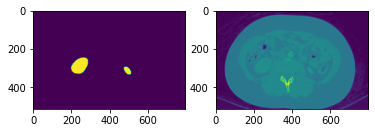

In [4]:
dataset = BaseDataset(config.image_path, config.val_mask_path, is_val=True)
result = calculate_classes(dataset)
print(result)

torch.Size([1, 107, 256, 256])
[{'voxel': 72240, 'loc': (10, 120, 157, 107, 166, 205), 'centroid': (62.516486710963456, 142.19957087486156, 181.06000830564784)}, {'voxel': 66724, 'loc': (0, 128, 67, 86, 179, 112), 'centroid': (42.944622624542895, 153.0084827048738, 89.2409327977939)}]


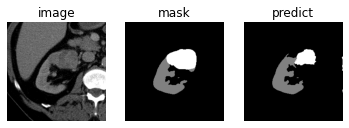

In [26]:
"""
1. predict patient nodule
"""

import torch
from utils.config import Config
from utils.message import Msg
from utils.validation import Validation
from utils.save import Save
from utils.convert import Convert
from utils.visualization import show_views
import segmentation_models_pytorch as smp
from net.baseNet import UNet_3d
from data.kits_dataset import KitsDataset
from data.BasisDataset import BaseDataset
from utils.visualization import show_image_hist, show_single_view, show_views
import os
from net.ResUnet import ResNetUNet
from configuration.labels import KITS_HEC_LABEL_MAPPING, HEC_NAME_LIST, HEC_SD_TOLERANCES_MM, GT_SEGM_FNAME

if __name__ == "__main__":
    msg = Msg()
    config = Config()
    validation = Validation()
    convert_file = Convert()
    save = Save()

    # model = UNet(n_channels=1, classes=2)
    config.pre_model_path = "./SwinUnet_Adam_0/CP_epoch3.pth"
#     model = UNet_2_skip(n_channels=1, classes=4)
    model = ResNetUNet(in_channel=1, classes=4)

#     model = UNet_3d(in_channels=1, classes=4)
    model.load_state_dict(torch.load(config.pre_model_path,
                                     map_location=config.device))
    model.to(device=config.device)
#     dataset = BaseDataset(config.val_image_crop,config.val_mask_crop,pre_pro=False)
#     mask = np.load(f"{config.val_mask_crop}/10_0_case_00288_.npy")
#     image = np.load(f"{config.val_image_crop}/10_0_case_00288_.npy")
#     mask = dataset[1]["mask"][0]
#     image = dataset[1]["image"][0]

    image_root = f"{config.val_image_crop}/10_0_case_00270_.npy"
    mask_root = f"{config.val_mask_crop}/10_0_case_00270_.npy"
    image_numpy = np.load(image_root)
    true_numpy = np.load(mask_root)
#     xcd fix
    patient_name = ""
#     images,_ = convert_file.nii_2_np(image_root)
#     mask ,spacing = convert_file.nii_2_np(mask_root)
# #     pri
#     images_numpy = torch.FloatTensor(images).unsqueeze(1)
#     true_mask= torch.FloatTensor(mask).unsqueeze(1)
                        
#     print(image_numpy)
    masks = validation.predict(model, np.expand_dims(image_numpy, 0), config)
#     # save
#     slice  = 10
    show_views(image_numpy, true_numpy,masks,cmap="gray")
         


In [28]:
from torch.nn import nn


2.0


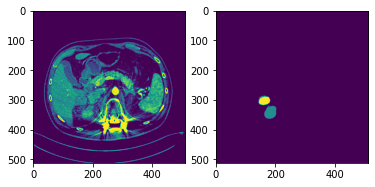

In [25]:
index = 6
show_views(image[index][0], mask[index][0])